# Analyse csp C-Terminal Variation 

## Introduction

The c-terminal domain of the _Plasmodium falciparum_ circumsporozoite protein (csp) has been targeted by the RTS,S and R21 vaccines, underscoring the importance of monitoring the variability of this region.

This notebook recreates the following figures from the [Pf7 paper](https://wellcomeopenresearch.org/articles/8-22):


*   **Figure 4A**: frequency of csp c-terminal haplotypes and global mean distances
*   **Figure 4B**: histograms of amino acid differences between subpopulations and 3D7 for csp c-terminal
*   **Supplementary Figure 10**: Barplot of non-reference allele proportions in different sub-populations.

**This notebook takes 5 minutes to run.**

## Setup

Install and import the malariagen Python package:


In [1]:
!pip install -q --no-warn-conflicts malariagen_data
import malariagen_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.2/146.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.5/302.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0

Import required python libraries that are installed at colab by default.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import re
import scipy
from google.colab import drive

## Access Pf7 Data

We use the malariagen data package to load the release data.

In [3]:
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()
# take a glance at the metadata dataframe
sample_metadata.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,True,Analysis_set,gDNA,True
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.85,True,Analysis_set,gDNA,True
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,86.46,True,Analysis_set,sWGA,False


## Access the csp c-terminal Haplotypes Data

 We can download the csp c-terminal region haplotypes for 16,203 samples from the MalariaGEN web resources using `wget` command.

In [4]:
!wget ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pf7_csp_c_terminal_haplotypes.txt

--2024-01-09 16:44:02--  ftp://ngs.sanger.ac.uk/production/malaria/Resource/34/Pf7_csp_c_terminal_haplotypes.txt
           => ‘Pf7_csp_c_terminal_haplotypes.txt’
Resolving ngs.sanger.ac.uk (ngs.sanger.ac.uk)... 193.62.203.79
Connecting to ngs.sanger.ac.uk (ngs.sanger.ac.uk)|193.62.203.79|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /production/malaria/Resource/34 ... done.
==> SIZE Pf7_csp_c_terminal_haplotypes.txt ... 10196635
==> PASV ... done.    ==> RETR Pf7_csp_c_terminal_haplotypes.txt ... done.
Length: 10196635 (9.7M) (unauthoritative)

Pf7_csp_c_terminal_ 100%[===================>]   9.72M  7.16MB/s    in 1.4s    

2024-01-09 16:44:05 (7.16 MB/s) - ‘Pf7_csp_c_terminal_haplotypes.txt’ saved [10196635]



In [5]:
# Read the data into a dataset
df_csp_haplotypes = pd.read_csv('Pf7_csp_c_terminal_haplotypes.txt', sep='\t', low_memory=False)

# Rename first column as 'Samples' in accordance with sample_metadata
df_csp_haplotypes = df_csp_haplotypes.rename(columns={df_csp_haplotypes.columns[0]: 'Sample'})

# Print first rows
df_csp_haplotypes.head()

,Sample,csp_277-397_aa_haplotype,csp_277-397_nucleotide_haplotype,csp_277-397_ns_changes
0,FP0008-C,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q
1,FP0009-C,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q
2,FP0010-CW,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,s301n/k314q/k317e/e318k/n321k/k322t/q324k/e357...
3,FP0011-CW,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDKHIEQYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K317E/E318Q/N321K/K322T/Q324K/D359N/A361E
4,FP0012-CW,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q


Let's merge the metadata and haplotypes dataframes, `sample_metadata` and `df_csp_haplotypes`, using `Sample` IDs.

In [6]:
df_samples = sample_metadata.merge(df_csp_haplotypes, on='Sample')
df_samples.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6,csp_277-397_aa_haplotype,csp_277-397_nucleotide_haplotype,csp_277-397_ns_changes
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,True,Analysis_set,gDNA,True,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.85,True,Analysis_set,gDNA,True,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,86.46,True,Analysis_set,sWGA,False,QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDQHIEKYLKT...,ctaattaaggaacaagaaggataataccattattaatcctattgaa...,s301n/k314q/k317e/e318k/n321k/k322t/q324k/e357...


As we examine a region comprising 121 amino acids, haplotypes exceeding this length are considered heterozygous calls, indicative of mixed infections.  Let's find out the percentage of samples that comprise 121 amino acids.


In [7]:
df_samples['csp_277-397_aa_haplotype'].apply(len).value_counts() / 16203*100

121    69.493304
244    20.551750
1       6.801210
243     3.178424
202     0.006172
177     0.006172
Name: csp_277-397_aa_haplotype, dtype: float64

We will only use homozygous calls for our subsequent analyses.

In [8]:
# Classify samples with expected haplotype length as homozygous
df_samples['c_terminal_hap_is_hom'] = ( df_samples['csp_277-397_aa_haplotype'].apply(len) == 121 )

## Frequency of csp c-terminal haplotypes and global mean distances

We will start with finding out the frequency of haplotypes.

The csp_277-397_ns_changes column provides information about nucleotide sequence changes in each sample. An empty value in this column indicates no change in the nucleotide sequence, and such haplotypes are referred to as 3D7, representing the reference sample in Pf7.



In [9]:
df_samples['csp_277-397_ns_changes'] = df_samples['csp_277-397_ns_changes'].fillna('3D7')

We can group the samples with identical nucleotide changes and count them using a simple function.

In [10]:

def my_agg(x):
    names = collections.OrderedDict()
    names['csp_277-397_aa_haplotype'] = x['csp_277-397_aa_haplotype']
    names['number_of_samples'] = len(x)
    return(pd.Series(names))

We will only apply the function to samples with homozygous calls, and lab strains will be excluded from the analysis.

In [11]:
df_haplotypes = pd.DataFrame(
    df_samples.loc[
        # Select only samples with homozygous calls
        ( df_samples['csp_277-397_aa_haplotype'].apply(len) == 121 ) &
        # Exclude the lab strains
        ( df_samples['Study'] != '1153-PF-Pf3KLAB-KWIATKOWSKI' )
        # Group samples by ns changes and apply the function to count samples
    ]).groupby('csp_277-397_ns_changes').apply(my_agg)

print(df_haplotypes.shape)
df_haplotypes.head()

(248, 2)


,csp_277-397_aa_haplotype,number_of_samples
csp_277-397_ns_changes,,
3D7,5 QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSD...,368
A297D/S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q,59 QGNGQGHNMPNDPNRNVDENDNANNAVKNNNNEEPSD...,2
A297S/S301N/K317E/E318Q/E357Q,11584 QGNGQGHNMPNDPNRNVDENSNANNAVKNNNNEEPSD...,1
A299D/S301N/K314Q/K317E/E318K/N321K/E357Q,505 QGNGQGHNMPNDPNRNVDENANDNNAVKNNNNEEPSD...,14
A299G/L327I/E357Q,1837 QGNGQGHNMPNDPNRNVDENANGNSAVKNNNNEEPSD...,8


Next, we will create a distance matrix based on pairwise differences to compute the global mean distance for each sample. The diagonal of the matrix is filled with NaN to exclude self-comparisons.

In [12]:
# Initialize distance matrix
haplotype_distance_matrix = np.zeros((len(df_haplotypes), len(df_haplotypes)))

# Populate distance matrix
for i in range(len(df_haplotypes)):
    for j in range(len(df_haplotypes)):
        # Select the first copy of the haplotype for comparison
        hap1 = df_haplotypes.iloc[i, 0].values[0]
        hap2 = df_haplotypes.iloc[j, 0].values[0]
        haplotype_distance_matrix[i, j] = np.count_nonzero(np.array(list(hap1)) != np.array(list(hap2)))

# Fill diagonal with NaN
np.fill_diagonal(haplotype_distance_matrix, np.nan)

# Print the shape and the distance matrix
print(haplotype_distance_matrix.shape)
print(haplotype_distance_matrix)

(248, 248)
[[nan  9.  5. ...  8.  8.  8.]
 [ 9. nan  6. ...  4.  6.  4.]
 [ 5.  6. nan ...  6.  5.  6.]
 ...
 [ 8.  4.  6. ... nan  5.  2.]
 [ 8.  6.  5. ...  5. nan  6.]
 [ 8.  4.  6. ...  2.  6. nan]]


After creating the distance matrix, each row in the matrix represents the global mean distance for each sample. Finally, the samples are sorted based on their global mean distance for visual purposes of the figure.

In [13]:
df_haplotypes['global_mean_distance'] = np.nanmean(haplotype_distance_matrix, axis=0)
df_haplotypes.sort_values('global_mean_distance', inplace=True)
df_haplotypes

,csp_277-397_aa_haplotype,number_of_samples,global_mean_distance
csp_277-397_ns_changes,,,
S301N/K317E/E318Q/N321K/E357Q/A361E,10856 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,3,4.647773
S301N/K317E/E318Q/N321K/A361E,712 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,2760,4.708502
S301N/K317E/N321K/A361E,6736 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSDK...,1,4.805668
S301N/K317E/E318Q/N321K/K322T/E357Q/A361E,4581 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,6,4.951417
S301N/K314Q/K317E/E318K/N321K/E357Q/A361E,15085 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,1,5.032389
...,...,...,...
S301N/L327I/N352G/D356E/D359N/A361E,13069 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,1,8.570850
K317T/N321K/N352G/P354S/D356N/A361E,15402 QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSD...,1,8.655870
D294N/S301N/N321T/L327I/N352G/D359N/A361E,8343 QGNGQGHNMPNDPNRNVNENANANNAVKNNNNEEPSDK...,1,8.724696


We would like to show haplotypes found in some lab strains. We haplotype-match these lab strains and store them in a new dataframe.

In [53]:
df_haplotypes_lab = df_haplotypes.loc[df_haplotypes.index.isin(df_samples.loc[df_samples['Study'] == '1153-PF-Pf3KLAB-KWIATKOWSKI', 'csp_277-397_ns_changes'])]

# List of labels
labels = ['Dd2', 'IT', '7G8', 'GB4', '3D7', 'HB3']

# Create 'labels' column
df_haplotypes_lab= df_haplotypes_lab.copy()
df_haplotypes_lab.loc[:, 'labels'] = labels
df_haplotypes_lab

,csp_277-397_aa_haplotype,number_of_samples,global_mean_distance,labels
csp_277-397_ns_changes,,,,
S301N/K317E/E318Q/N321K/A361E,712 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,2760,4.708502,Dd2
S301N/K317E/E318Q/N321K/N352D/E357Q/A361E,3090 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,80,5.259109,IT
S301N/K317E/E318Q/N321K/Q324K/L327I/A361E,23 QGNGQGHNMPNDPNRNVDENANANNAVKNNNNEEPSD...,125,5.558704,7G8
N298K/S301N/N321K/K322I,2174 QGNGQGHNMPNDPNRNVDENAKANNAVKNNNNEEPSD...,4,6.736842,GB4
3D7,5 QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSD...,368,6.882591,3D7
D288N/S301N/K317E/E318Q/N321K/N352G/P354S/A361E,92 QGNGQGHNMPNNPNRNVDENANANNAVKNNNNEEPSD...,47,7.210526,HB3


### Plotting

We are ready to create the first plot which will have 2 subplots - one for showing the haplotype frequencies and the other one for showing the global mean distance. Then, we will paint lab strains with red colour using `df_haplotypes_lab` dataset.

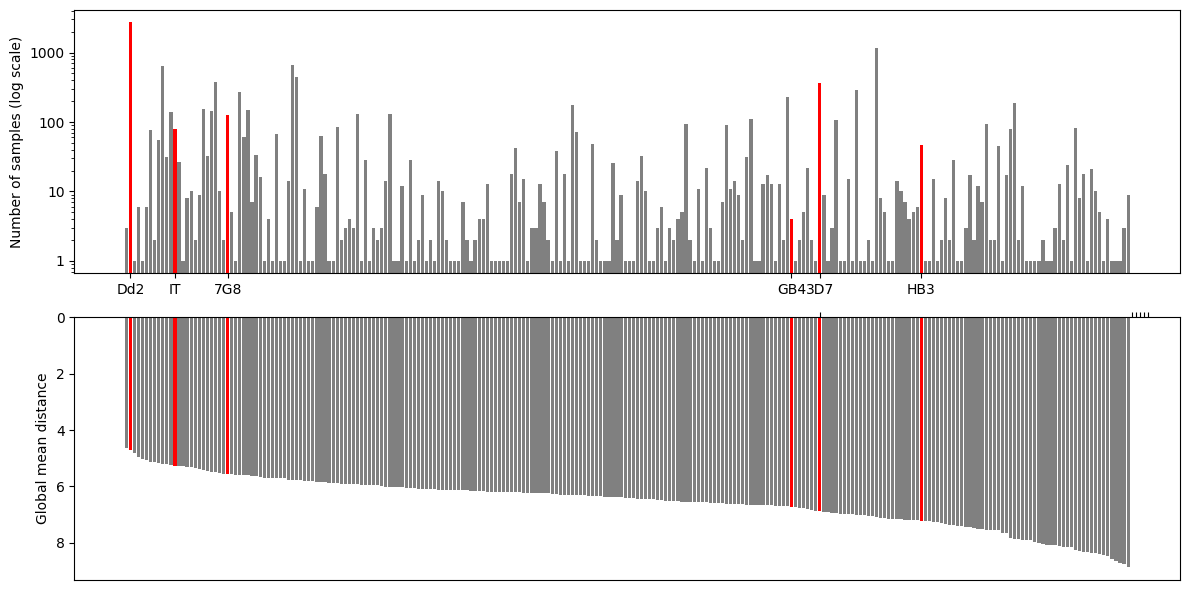

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
axs[0].bar(df_haplotypes.index, df_haplotypes['number_of_samples'], log='y', color='grey')
axs[0].bar(df_haplotypes_lab.index, df_haplotypes_lab['number_of_samples'], log='y', color='red')
axs[0].set_yticks([1, 10, 100, 1000])
axs[0].set_yticklabels([1, 10, 100, 1000])
axs[0].set_xticks(df_haplotypes_lab.index)
axs[0].set_xticklabels(df_haplotypes_lab.labels)
axs[0].set_ylabel('Number of samples (log scale)')
# axs[0].set_ylim([0.8, 3000])

axs[1].bar(df_haplotypes.index, df_haplotypes['global_mean_distance'], color='grey')
axs[1].bar(df_haplotypes_lab.index, df_haplotypes_lab['global_mean_distance'], color='red')
# axs[1].set_xticks([])
axs[1].set_xticks(df_haplotypes_lab.labels)
axs[1].set_xticklabels([])
axs[1].set_ylabel('Global mean distance')
axs[1].invert_yaxis()
axs[1].xaxis.tick_top()

fig.tight_layout()

**Figure Legend: Analysis of c-terminal of csp.**
Upper panel - frequency of different haplotypes of c-terminal of csp. Haplotypes found in some lab strains are named and highlighted in red. Haplotypes are ordered as per lower panel. Lower panel - global mean distance (number of amino acid differences) to all other haplotypes.

### Save the plot

We can save the plot by running:

In [16]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/figure_csp_c_terminal_all_haplotypes.pdf', dpi=480, bbox_inches="tight") # increase the dpi for higher resolution

## Histograms of Amino Acid Differences Between Subpopulations for csp c-terminal

Before creating this figure, we need to count the number of nucleotide changes within samples.


### Count amino acid differences to non-3D7 haplotypes

Short way of counting substitions is using the  `csp_277-397_ns_changes` column in the dataframe. Since different substutions are concatanated using '/' (i.e. D288N/S301N), we will first split the string and then find the count.

In [18]:
def determine_num_aa_changes(x):
    if x == '' or x is None:
        return(0)
    else:
        return(len(x.split(',')[0].split('/')))


df_samples_hom = df_samples.loc[df_samples['c_terminal_hap_is_hom']]

df_samples.loc[df_samples['c_terminal_hap_is_hom'] == True, 'csp_277-397_ns_changes'].apply(determine_num_aa_changes).value_counts()

5     3008
8     2087
6     1894
7     1876
9     1704
1      374
4      222
10      45
2       33
3       17
Name: csp_277-397_ns_changes, dtype: int64

The long way of counting the amino acid differences is by cross-matching the haplotype sequence with the reference and counting the differences.

In [19]:
def determine_num_aa_changes_from_haplotype(
    x,
    # 3D7 haplotype
    haplotype='QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYANDIEKKICKMEKCSSVFNVVNSSIGLIMVLSFLFLN'
):
    num_aa_changes = 0
    if len(x) != len(haplotype):
        return(0)
#         raise ValueError(f"Length of x ({len(x)}) different to that of haplotype ({len(haplotype)})")
    for i in np.arange(len(x)):
        if x[i] != haplotype[i]:
            num_aa_changes += 1
    return(num_aa_changes)

(
    df_samples_hom['csp_277-397_aa_haplotype']
    .fillna('')
    .apply(
        lambda x: determine_num_aa_changes_from_haplotype(
            x,
            # 3D7
            'QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYANDIEKKICKMEKCSSVFNVVNSSIGLIMVLSFLFLN'
        )
    )
    .value_counts()
)

5     3008
8     2087
6     1894
7     1876
9     1704
0      369
4      222
10      45
2       33
3       17
1        5
Name: csp_277-397_aa_haplotype, dtype: int64

Both methods gave the same results.

### Count numbers of amino acid differences from each haplotype for each sample

We already found the amino acid differences to 3D7, as a bonus step, we can utilize the same function to count amino acid differences between each haplotype.

In [20]:
# Df to store haplotype counts in samples
num_aa_changes =  df_samples_hom.copy()

# Ignore the dirty performance warning
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Iterate over each haplotype
for haplotype in df_samples_hom['csp_277-397_aa_haplotype'].unique():
    print('.', end='')

    # Pick the corresponding substitutions (aa_changes) for the haplotype
    aa_changes = df_samples_hom.loc[df_samples_hom['csp_277-397_aa_haplotype'] == haplotype, 'csp_277-397_ns_changes'].values[0]

    # Create a column for aa_changes
    # Apply function to find number of changes
    num_aa_changes.loc[:,aa_changes] = (
        df_samples['csp_277-397_aa_haplotype']
        .apply(
            lambda x: determine_num_aa_changes_from_haplotype(
                x,
                haplotype
            )
        )
    )

........................................................................................................................................................................................................................................................

### Create plot showing differences between 3D7 and Dd2 haplotypes

Let's define a colour to each subpopulation to be used in the figure.

In [21]:
population_colours = collections.OrderedDict()
population_colours['SA']= "#4daf4a"
population_colours['AF-W']= "#e31a1c"
population_colours['AF-C'] = "#fd8d3c"
population_colours['AF-NE'] = "#bb8129"
population_colours['AF-E'] = "#fecc5c"
population_colours['AS-S-E'] = "#dfc0eb"
population_colours['AS-S-FE'] = "#984ea3"
population_colours['AS-SE-W'] = "#9ecae1"
population_colours['AS-SE-E'] = "#3182bd"
population_colours['OC-NG'] = "#f781bf"


In this plot:

- Each subplot represents samples from a distinct subpopulation.
- The x-axis denotes the number of amino acid differences, ranging from 1 to 10.
- The y-axis indicates the corresponding number of samples.
- In addition to the 3D7 reference, substitutions to the Dd2 reference will also be featured in the analysis.

Text(0.05, 0.5, 'Frequency (number of samples with this number of\namino acid differences from given haplotype)')

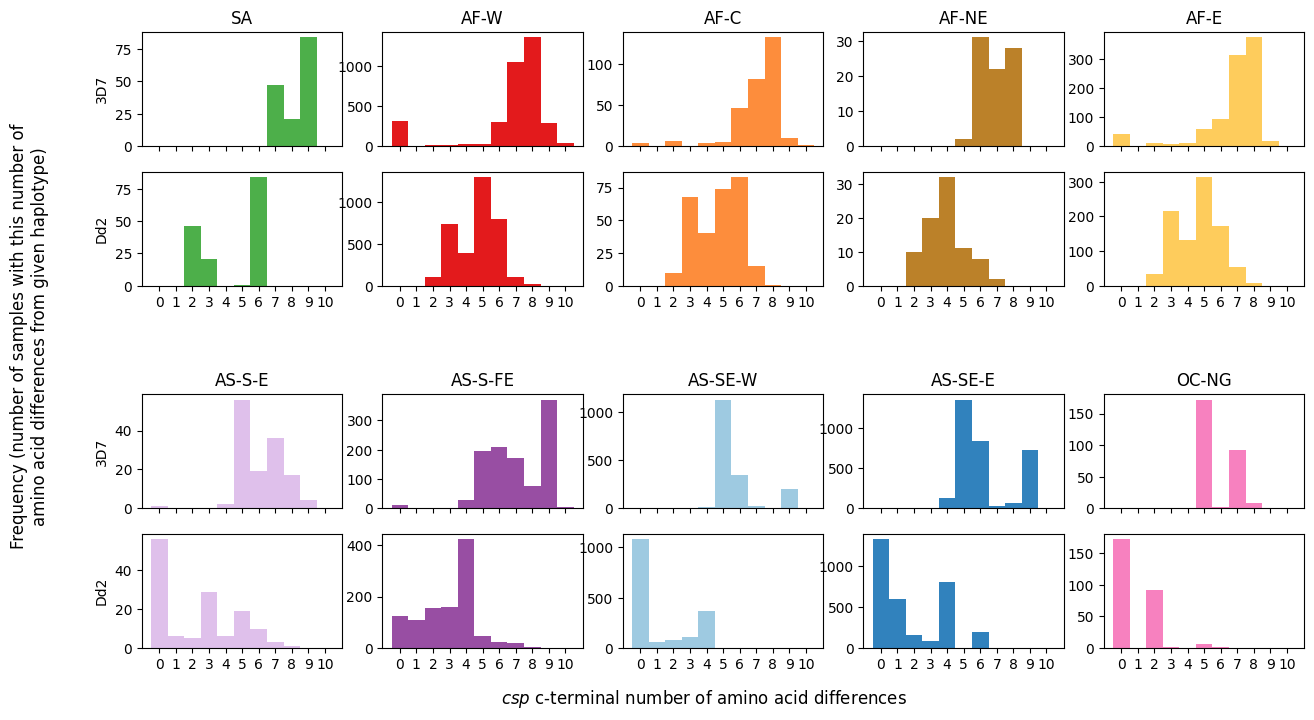

In [22]:
# Create a 5x5 grid of subplots with specified dimensions and spacing
fig, axs = plt.subplots(5, 5, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 1, 0.5, 1, 1], 'hspace': 0.25})

# Define an ordered dictionary to hold references and associated labels for each subplot
plots = collections.OrderedDict()
plots['3D7'] = '3D7'
plots['S301N/K317E/E318Q/N321K/A361E'] = 'Dd2'

# Loop through each reference in the plots dictionary
for plot_num, aa_changes in enumerate(plots):
    # Loop through each subpopulation and enumerate its index
    for pop_num, population in enumerate(population_colours):
        # Calculate the subplot indices based on the current reference and subpopulation
        plot_index_row = (pop_num // 5) * 3 + (plot_num)
        plot_index_col = pop_num % 5

        # Extract the number of amino acid changes for the current subpopulation and reference
        num_csp_ns_mutations_this_pop = num_aa_changes.loc[
            (num_aa_changes['Population'] == population),
            aa_changes
        ].values

        # Create a histogram for the amino acid changes in the current subplot
        axs[plot_index_row, plot_index_col].hist(num_csp_ns_mutations_this_pop, bins=np.arange(0, 12),
                                                 color=population_colours[population])

        # Set x-axis ticks and labels for better readability
        axs[plot_index_row, plot_index_col].set_xticks(np.arange(0.5, 11))

        # Set subplot title for the first row and x-axis labels for the second row
        if plot_num == 0:
            axs[plot_index_row, plot_index_col].set_title(population, fontsize=12)
        if plot_num == 1:
            axs[plot_index_row, plot_index_col].set_xticklabels(np.arange(0, 11))
        else:
            axs[plot_index_row, plot_index_col].set_xticklabels([])

        # Set y-axis label for each subplot
        if plot_index_col == 0:
            axs[plot_index_row, plot_index_col].set_ylabel(plots[aa_changes])

# Turn off the middle row of subplots for aesthetic reasons
for column_num in np.arange(5):
    axs[2, column_num].axis('off')

# Add x-axis and y-axis labels to the entire figure
fig.text(0.5, 0.04, '$csp$ c-terminal number of amino acid differences', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'Frequency (number of samples with this number of\namino acid differences from given haplotype)',
         va='center', ha='center', fontsize=12, rotation=90)

**Figure Legend: Analysis of c-terminal of csp.** Histograms of number of amino acid differences between samples in each major sub-population and the 3D7 haplotype (upper plot) and Dd2 haplotype (lower plot).

### Save the plot

In [23]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/figure_csp_c_terminal_histogram.pdf', dpi=480, bbox_inches="tight") # increase the dpi for higher resolution

## Barplot of Non-reference Allele Proportions in Different Sub-populations

Before proceeding with plotting, we need to determine the allele proportions, a process that involves the following two steps:

1. Extracting mutations from the substitution column.
2. Calculating the count of each mutation within a subpopulation.


### Extracting mutations: Format and tidy-up substitutions column

Let's examine a value in the substitutions column to determine the appropriate method for extraction.

In [24]:
df_samples_hom['csp_277-397_ns_changes'][0]

'S301N/K314Q/K317E/E318K/N321K/K322T/Q324K/E357Q'

Since all mutations are split by the "/" character from each other, we can write a simple function to seperate them.

In [50]:
def tidylist(x):

    # Split mutations
    x = (x.split('/'))

    # Create list to store extractions
    tidy_list = []

    # Loop through item list
    for item in x:
        item=item.upper() # Convert all to caps
        item=item.replace("*", "") # Remove unknown characters
        item=item.replace("!", "") # Remove unknown characters
        tidy_list.append(item)
    return tidy_list

# Apply function and store the results in a new column
df_samples_hom= df_samples_hom.copy()
df_samples_hom['list'] = df_samples_hom['csp_277-397_ns_changes'].apply(tidylist)

### Extracting mutations: Unique mutations sorted by positon number

We will find unique mutations and sort them by positions in ascending order which will be useful for the final figure.

In [26]:
# Create array of all mutation types
# Find all unique mutations
unique_array = df_samples_hom['list'].explode().unique()

# Sort by positions (second character of string)
unique_array=sorted(unique_array,key=lambda t: t[1:])


Now, we will flag samples for the presence of these mutations, assigning `True` if they exist and `False` if they do not.

In [27]:
# Create boolean data frame, showing True or False values for each mutation
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    # Loop through all the tags
    for item in unique_items:
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

ns_bool = boolean_df(df_samples_hom['list'], unique_array)
ns_bool.head()

,H283R,D288G,D288N,V293A,D294N,E295A,E295D,E295K,N296D,N296S,...,D356N,E357K,E357Q,D359N,A361E,A361I,A361K,A361S,L391F,3D7
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


 We will use the index of the samples to match sample populations from the `df_samples` since we have not resetted index so far.

In [28]:
# Make dictionary of sample and population
dictionary = dict(zip(df_samples_hom.index,df_samples_hom.Population))
# Map population to boolean dataframe using dictionary and set as index
ns_bool['population']= ns_bool.index.map(dictionary)
# Change sample names to population
ns_bool=ns_bool.set_index(['population'])
ns_bool

,H283R,D288G,D288N,V293A,D294N,E295A,E295D,E295K,N296D,N296S,...,D356N,E357K,E357Q,D359N,A361E,A361I,A361K,A361S,L391F,3D7
population,,,,,,,,,,,,,,,,,,,,,
AF-W,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
AF-W,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
AF-W,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False
AF-W,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
AF-W,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AF-E,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,False,False,False,False,False
AF-E,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
AF-E,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


### Formatting: Add columns for aa position, and amino acids before and after

Before calculating allele frequencies, some data formatting is required. We will transverse the dataframe to extract: aa_positions, wild-type and mutation.

In [29]:
#Transverse dataframe to calculate bool counts for each amino acid position change
ns_bool_T = ns_bool.T
ns_bool_T.head()

#Copy this data frame to modify later on when selecting my population
ns_bool_T_original = ns_bool_T.copy()

In [30]:
# Convert index to column
ns_bool_T = ns_bool.T.reset_index().rename(columns={'index': 'aa_change'})

# Drop last row - 3D7
ns_bool_T = ns_bool_T.drop(ns_bool_T.index[-1])

# Split aa_change column into the position, original amino acid, and mutated amino acid
ns_bool_T['aa_position']=ns_bool_T['aa_change'].str[1:4].astype(int)
ns_bool_T['OG_aa']=ns_bool_T['aa_change'].str[0]
ns_bool_T['mut_aa']=ns_bool_T['aa_change'].str[-1]
ns_bool_T.head()

# Make copy to use later
pop_bool = ns_bool_T.copy()

We can easily count how many mutations within each sample and find the frequency by dividing overall population size.

In [31]:
# Add count columnns
ns_bool_T['count']=ns_bool_T[['AF-W','AS-SE-E','AS-SE-W','AS-S-FE','AF-C','OC-NG','AF-NE', 'AS-S-E','SA','AF-E']].sum(axis=1) #create column for count

In [32]:
# Add count percentage column
df_samples.shape
pop_size=len(df_samples_hom)

# Normalise by population.
ns_bool_T['count_percentage']=ns_bool_T['count'].apply(lambda x: (x/pop_size)*100)

# Add ranking column
ns_bool_T=ns_bool_T.reset_index(drop=True).sort_values(by=['aa_position', 'count_percentage'], ascending=[True, False])
ns_bool_T['alt_acid_number'] = ns_bool_T.groupby(['aa_position']).cumcount()+1; ns_bool_T

# Make dictionary of alt_acid mumher and aa_change to map later on when looking at populations
rank_dict = dict(zip(ns_bool_T['aa_change'].to_list(), ns_bool_T['alt_acid_number'].to_list()))

In order to create stacked bars in the plot, we will create multi-level index.

In [33]:
#set index
ns_bool_T = ns_bool_T.set_index(['aa_position', 'OG_aa','alt_acid_number'])

pd.set_option('display.max_rows', 100)
ns_bool_T

population                        aa_change   AF-W   AF-W   AF-W   AF-W  \
aa_position OG_aa alt_acid_number                                         
283         H     1                   H283R  False  False  False  False   
288         D     1                   D288N  False  False  False  False   
                  2                   D288G  False  False  False  False   
293         V     1                   V293A  False  False  False  False   
294         D     1                   D294N  False  False  False  False   
295         E     1                   E295K  False  False  False  False   
                  2                   E295A  False  False  False  False   
                  3                   E295D  False  False  False  False   
296         N     1                   N296D  False  False  False  False   
                  2                   N296S  False  False  False  False   
297         A     1                   A297D  False  False  False  False   
                  2                   A297S  False  False  False  False   
298         N     1                   N298K  False  False  False  False   
299         A     1                   A299G  False  False  False  False   
                  2                   A299S  False  False  False  False   
                  3                   A299D  False  False  False  False   
301         S     1                   S301N   True   True   True   True   
                  2                   S301D  False  False  False  False   
302         A     1                   A302D  False  False  False  False   
                  2                   A302G  False  False  False  False   
                  3                   A302P  False  False  False  False   
                  4                   A302V  False  False  False  False   
303         V     1                   V303A  False  False  False  False   
                  2                   V303E  False  False  False  False   
                  3                   V303G  False  False  False  False   
305         N     1                   N305K  False  False  False  False   
310         E     1                   E310V  False  False  False  False   
314         K     1                   K314Q   True   True  False   True   
317         K     1                   K317E   True   True   True   True   
                  2                   K317T  False  False  False  False   
318         E     1                   E318Q  False  False   True  False   
                  2                   E318K   True   True  False   True   
                  3                   E318D  False  False  False  False   
320         L     1                   L320I  False  False  False  False   
321         N     1                   N321K   True   True   True   True   
                  2                   N321Q  False  False  False  False   
                  3                   N321T  False  False  False  False   
                  4                   N321P  False  False  False  False   
322         K     1                   K322T   True   True   True   True   
                  2                   K322N  False  False  False  False   
                  3                   K322I  False  False  False  False   
                  4                   K322R  False  False  False  False   
                  5                   K322E  False  False  False  False   
                  6                   K322L  False  False  False  False   
323         I     1                   I323M  False  False  False  False   
324         Q     1                   Q324K   True   True   True   True   
                  2                   Q324R  False  False  False  False   
325         N     1                   N325Y  False  False  False  False   
326         S     1                   S326A  False  False  False  False   
327         L     1                   L327I  False  False  False  False   
349         G     1                   G349D  False  False  False  False   
                  2      

### Figure preparation

The last step is doing unstacking and grouping operations to prepare our data in a format suitable for creating a stacked bar plot.

 #### UNSTACK - for count percentage values

In [34]:
# Unstack index by count percentage and groupby amino acid position
count_unstacked = ns_bool_T['count_percentage'].unstack().groupby(['aa_position','OG_aa']).first()
count_unstacked

,alt_acid_number,1,2,3,4,5,6
aa_position,OG_aa,,,,,,
283,H,0.008881,NaN,NaN,NaN,NaN,NaN
288,D,0.639432,0.026643,NaN,NaN,NaN,NaN
293,V,0.008881,NaN,NaN,NaN,NaN,NaN
294,D,1.216696,NaN,NaN,NaN,NaN,NaN
295,E,0.275311,0.062167,0.017762,NaN,NaN,NaN
296,N,0.266430,0.017762,NaN,NaN,NaN,NaN
297,A,0.017762,0.008881,NaN,NaN,NaN,NaN
298,N,6.820604,NaN,NaN,NaN,NaN,NaN
299,A,0.648313,0.186501,0.124334,NaN,NaN,NaN


In order to add non-substutional positions in the figure, we will create a dataframe with empty calls and merge with `count_unstacked` dataset to fill the above percentages.

In [35]:
#Create new data frame with empty calls and merge with this one!
aa_position=np.arange(277,363)
og_aa=list("QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYAN")
tuples=list(zip(aa_position,og_aa))

In [36]:
cols = count_unstacked.columns
index = pd.MultiIndex.from_tuples(tuples, names=['aa_position', 'OG_aa'])
empty_df = pd.DataFrame(np.nan,index, cols)
count_unstacked
empty_df

,alt_acid_number,1,2,3,4,5,6
aa_position,OG_aa,,,,,,
277,Q,NaN,NaN,NaN,NaN,NaN,NaN
278,G,NaN,NaN,NaN,NaN,NaN,NaN
279,N,NaN,NaN,NaN,NaN,NaN,NaN
280,G,NaN,NaN,NaN,NaN,NaN,NaN
281,Q,NaN,NaN,NaN,NaN,NaN,NaN
282,G,NaN,NaN,NaN,NaN,NaN,NaN
283,H,NaN,NaN,NaN,NaN,NaN,NaN
284,N,NaN,NaN,NaN,NaN,NaN,NaN
285,M,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#fill empty data frame with data to plot values ---- complete! & fill nan's with a zero int value so that the bars will plot
data_to_plot = empty_df.fillna(count_unstacked).fillna(0)

#### UNSTACK for amino acid lists

Second and last dataframe will convey amino acids instead of percentages.

In [38]:
#Unstack index by count percentage and groupby amino acid position
mut_aa_unstacked = ns_bool_T['mut_aa'].unstack().groupby(['aa_position','OG_aa']).first()

mut_aa_test = empty_df.fillna(mut_aa_unstacked).fillna(" ")

one=mut_aa_test[1].to_list()
two=mut_aa_test[2].to_list()
three=mut_aa_test[3].to_list()
four=mut_aa_test[4].to_list()
five=mut_aa_test[5].to_list()
six=mut_aa_test[6].to_list()

mut_aa_test

,alt_acid_number,1,2,3,4,5,6
aa_position,OG_aa,,,,,,
277,Q,,,,,,
278,G,,,,,,
279,N,,,,,,
280,G,,,,,,
281,Q,,,,,,
282,G,,,,,,
283,H,R,,,,,
284,N,,,,,,
285,M,,,,,,


Insert empty rows for all amino acids in sequence.

In [39]:
#Use 'test.reset_index().index' to set in plotting to set x_ticks
test=data_to_plot.copy()
test.reset_index().index

RangeIndex(start=0, stop=86, step=1)

### Plotting

There are three versions of this plot that we will go through one by one:   

1.   Showing allele proportions for Pf7
2.   Showing allele proportions for one subpopulation
3.   Showing allele proportions for Pf7 by subpopulations



#### Showing allele proportions for Pf7

We can assign a color to each rank of the alternate amino acid (1-6). We will display the corresponding colors in the legend.

In [40]:
# Make color dictionary
column_list=[1,2,3,4,5,6,]
color_list=['#0a2530', '#0796a9', '#d5e369', '#dc9922', '#943722', '#4e1b0f',]
columns_and_colors = (zip(column_list, color_list))
colors=dict(columns_and_colors)

We will create a stacked bar graph illustrating the percentage of samples with alternative amino acids. The primary axis (ax1) will display the stacked bars for each position, while secondary axes (ax2) underneath will depict alternative amino acid labels.

Text(0.081, 0.1, 'Alternate Amino Acid')

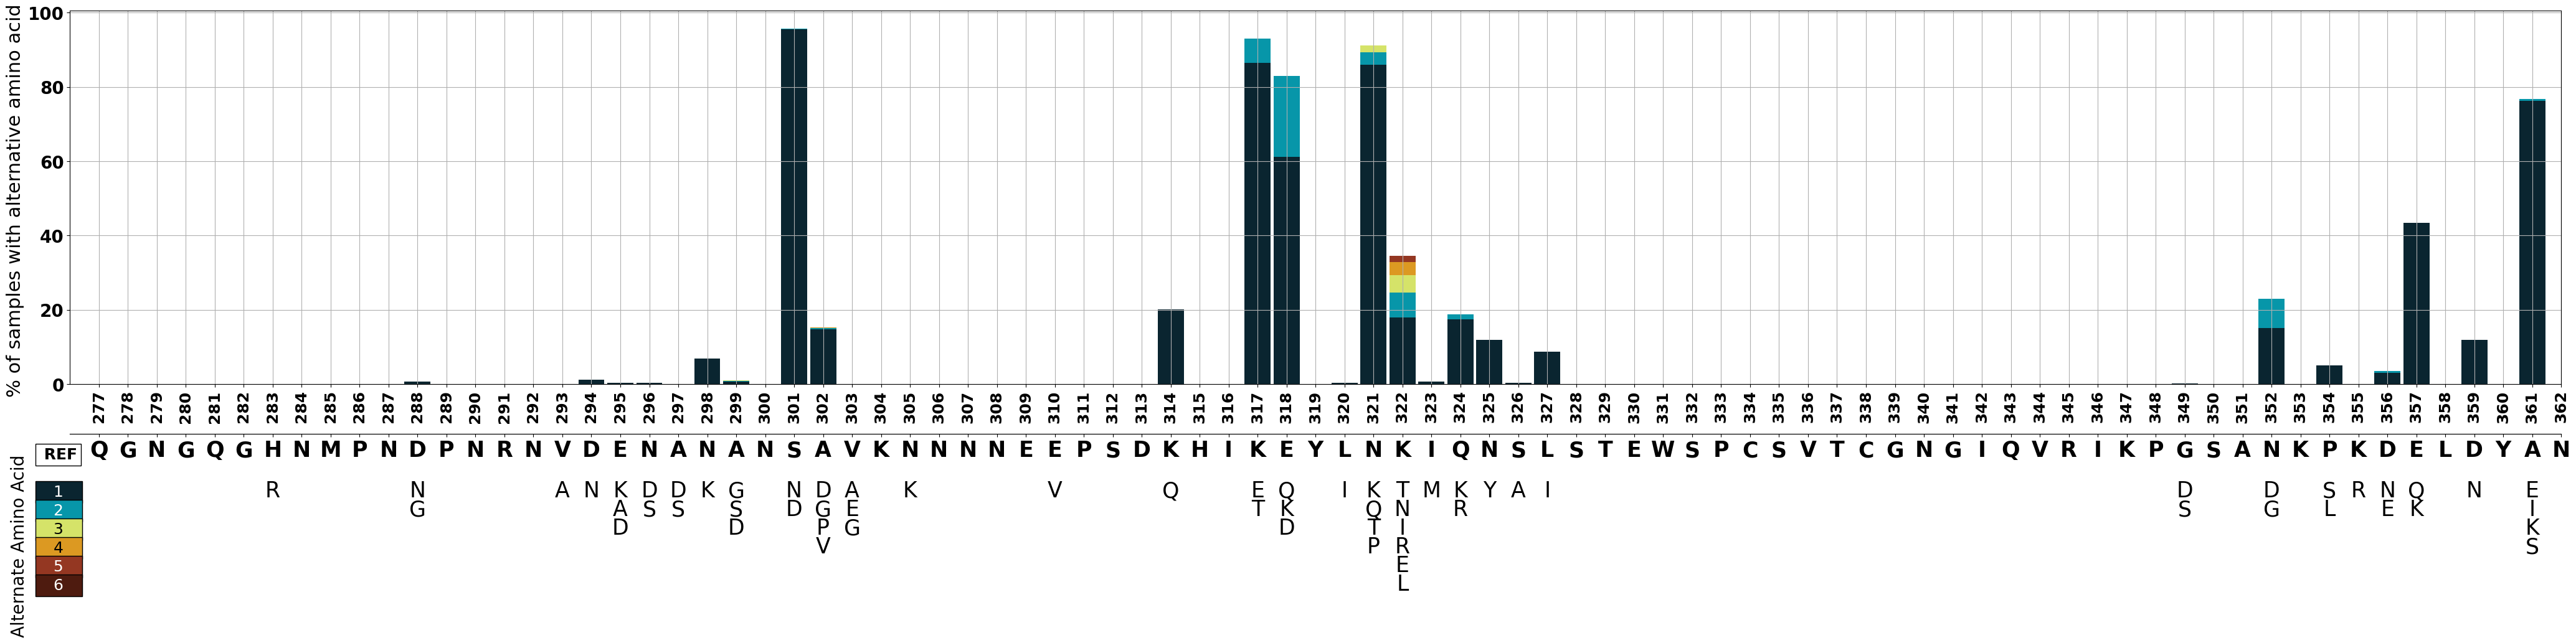

In [41]:
# Set figure
fig= plt.figure()
# Create first axis
ax1 = fig.add_axes((0.1,0.5,0.8,0.6))
# Plot bar graph on ax 1
ax1 = data_to_plot.plot(kind='bar',
                    stacked=True,
                    y=[1,2,3,4,5,6],
                    figsize=(50,10),
                    width=0.9,
                    color=[colors[i] for i in column_list],
                    linewidth = 0,
                    grid=True,
                    ax=ax1,
                    sharex = True,
                    legend=False)


#--------------------------------------------------------------------------------------------------------------------
#BAR GRAPH
#--------------------------------------------------------------------------------------------------------------------
#y axis of bar graph
ax1.set_ylabel("% of samples with alternative amino acid ", fontsize=22)
ax1.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels(["0","20","40","60","80","100"], fontweight='bold',fontsize=20)
#ax1.set_yscale('log')

#--------------------------------------------------------------------------------------------------------------------
#x axis of bar graph
ax1.set_xlim(-1,85)
ax1.set_xticks(test.reset_index().index)
ax1.set_xlabel(' ')
ax1.set_xticklabels(aa_position, fontweight='bold', fontsize=18)

#--------------------------------------------------------------------------------------------------------------------
# create secondary axis underneath
#--------------------------------------------------------------------------------------------------------------------
#Create OG aa x axis
ax2 = fig.add_axes((0.1,0.42,0.8,0.0))
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
og_aa_plot=list("QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYAN")
ax2.set_xticklabels(og_aa_plot,fontweight='bold',fontsize=25)

#--------------------------------------------------------------------------------------------------------------------
#Create 1st alt x axis
ax2 = fig.add_axes((0.1,0.35,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(one, fontsize=25)


#--------------------------------------------------------------------------------------------------------------------
#Create 2nd  alt x axis
ax2 = fig.add_axes((0.1,0.32,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(two,fontsize=25)


#--------------------------------------------------------------------------------------------------------------------
#Create 3rd alt x axis
ax2 = fig.add_axes((0.1,0.29,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(three,fontsize=25)


#--------------------------------------------------------------------------------------------------------------------
#Create 4rd alt x axis
ax2 = fig.add_axes((0.1,0.26,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(four,fontsize=25)


#--------------------------------------------------------------------------------------------------------------------
#Create 5rd alt x axis
ax2 = fig.add_axes((0.1,0.23,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(five,fontsize=25)


#--------------------------------------------------------------------------------------------------------------------
#Create 6rd alt x axis
ax2 = fig.add_axes((0.1,0.20,0.8,0.0), frameon=False)
ax2.yaxis.set_visible(False) # hide the yaxis
ax2.set_xlim(-1,85)
ax2.set_xticks(test.reset_index().index)
ax2.tick_params(length=0)
ax2.set_xticklabels(six,fontsize=25)

# Legend
# Add text boxes for alternative amino acid labelling

fig.text(0.09,0.38, " REF",   bbox=dict(facecolor='white'  ), fontsize=18, fontweight='bold')
fig.text(0.09,0.32, "   1   ", bbox=dict(facecolor=colors[1]), fontsize=18, color='white' )
fig.text(0.09,0.29, "   2   ", bbox=dict(facecolor=colors[2]), fontsize=18, color='white')
fig.text(0.09,0.26, "   3   ", bbox=dict(facecolor=colors[3]), fontsize=18 )
fig.text(0.09,0.23, "   4   ", bbox=dict(facecolor=colors[4]), fontsize=18 )
fig.text(0.09,0.20, "   5   ", bbox=dict(facecolor=colors[5]), fontsize=18,color='white' )
fig.text(0.09,0.17, "   6   ", bbox=dict(facecolor=colors[6]), fontsize=18,color='white' )

fig.text(0.081,0.10, "Alternate Amino Acid",rotation=90, fontsize=20)

**Figure Legend: Variation in c-terminal of csp in Pf7 samples.**

#### Showing allele proportions for one subpopulation

To generate the depicted plot for a specific population, we need to filter the data corresponding to that population and normalize the allele proportions based on the population size. We will create a function that performs these two steps, and the remaining part of the plot remains the same as above.

In [62]:
def make_pop_plots(pop_bool, pop, pop_size):

    ns_bool_T = pop_bool[[pop, 'aa_change', 'aa_position', 'OG_aa', 'mut_aa']]

    # Add count columnns
    ns_bool_T=ns_bool_T.copy()
    ns_bool_T.loc[:, 'count'] = ns_bool_T[[pop]].sum(axis=1)  # create column for count

    # Add count percentage
    ns_bool_T.loc[:, 'count_percentage'] = ns_bool_T['count'].apply(lambda x: (x/pop_size)*100)  # Normalize by population

    # Add ranking column
    ns_bool_T=ns_bool_T.reset_index(drop=True).sort_values(by=['aa_position', 'count_percentage'], ascending=[True, False])
    ns_bool_T['alt_acid_number'] = ns_bool_T['aa_change'].map(rank_dict)

    # Set index
    ns_bool_T = ns_bool_T.set_index(['aa_position', 'OG_aa','alt_acid_number'])

    # Unstack index by count percentage and groupby amino acid position
    count_unstacked = ns_bool_T['count_percentage'].unstack().groupby(['aa_position','OG_aa']).first()

    # Create new data frame with empty calls and merge with this one!
    aa_position=np.arange(277,363)
    og_aa=list("QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYANDIEKKICKMEKCSSVFNVVNSSIGLIMVL")
    tuples=list(zip(aa_position,og_aa))

    cols = count_unstacked.columns
    index = pd.MultiIndex.from_tuples(tuples, names=['aa_position', 'OG_aa'])
    empty_df = pd.DataFrame(np.nan,index, cols)
    count_unstacked
    empty_df

    # Fill empty data frame with data to plot values ---- complete! & fill nan's with a zero int value so that the bars will plot
    pd.set_option('display.max_rows', 115)
    data_to_plot = empty_df.fillna(count_unstacked).fillna(0)

    # Turn count into an int and only select rows with count >0
    ns_bool_T['count']=ns_bool_T['count'].apply(lambda x: int(x))
    ns_bool_T.loc[ns_bool_T['count']> 0] #this is diff from all populations, need to select only those with count > 0

    # Unstack index by count percentage and groupby amino acid position
    mut_aa_unstacked = ns_bool_T.loc[ns_bool_T['count']> 0]['mut_aa'].unstack().groupby(['aa_position','OG_aa']).first()

    # Create alternative amino acid axis context
    mut_aa_test = empty_df.fillna(mut_aa_unstacked).fillna(" ")
    mut_aa_test

    one=mut_aa_test[1].to_list()
    two=mut_aa_test[2].to_list()
    three=mut_aa_test[3].to_list()
    four=mut_aa_test[4].to_list()
    five=mut_aa_test[5].to_list()
    six=mut_aa_test[6].to_list()

    # Make index range for column lenght in df.plot
    test=data_to_plot.copy()
    test.reset_index().index

    og_aa_plot=list("QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYAN")

    #Set figure
    fig= plt.figure()
    #Create first axis
    ax1 = fig.add_axes((0.1,0.5,0.8,0.6))
    #Plot bar graph on ax 1
    ax1 = data_to_plot.plot(kind='bar',
                        stacked=True,
                        y=[1,2,3,4,5,6],
                        figsize=(50,10),
                        width=1,
                        color=[colors[i] for i in data_to_plot.columns],
                        linewidth = 0,
                        grid=True,
                        ax=ax1,
                        sharex = True,
                        legend=False)

    ax1.set_title(pop, fontsize=30)
    #--------------------------------------------------------------------------------------------------------------------
    #BAR GRAPH
    #--------------------------------------------------------------------------------------------------------------------
    #y axis of bar graph
    ax1.set_ylabel("% of samples with alternative amino acid ", fontsize=22)
    ax1.set_yticks([0,20,40,60,80,100])
    ax1.set_yticklabels(["0","20","40","60","80","100"], fontweight='bold',fontsize=20)
    #ax1.set_yscale('log')

    #--------------------------------------------------------------------------------------------------------------------
    #x axis of bar graph
    ax1.set_xlim(-1,85)
    ax1.set_xticks(test.reset_index().index)
    ax1.set_xlabel(' ')
    ax1.set_xticklabels(aa_position, fontweight='bold', fontsize=18)

    #--------------------------------------------------------------------------------------------------------------------
    # create secondary axis underneath
    #--------------------------------------------------------------------------------------------------------------------
    #Create OG aa x axis
    ax2 = fig.add_axes((0.1,0.42,0.8,0.0))
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.set_xticklabels(og_aa_plot,fontweight='bold',fontsize=25)

    #--------------------------------------------------------------------------------------------------------------------
    #Create 1st alt x axis
    ax2 = fig.add_axes((0.1,0.35,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(one, fontsize=25)


    #--------------------------------------------------------------------------------------------------------------------
    #Create 2nd  alt x axis
    ax2 = fig.add_axes((0.1,0.32,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(two,fontsize=25)




    #--------------------------------------------------------------------------------------------------------------------
    #Create 3rd alt x axis
    ax2 = fig.add_axes((0.1,0.29,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(three,fontsize=25)


    #--------------------------------------------------------------------------------------------------------------------
    #Create 4rd alt x axis
    ax2 = fig.add_axes((0.1,0.26,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(four,fontsize=25)


    #--------------------------------------------------------------------------------------------------------------------
    #Create 5rd alt x axis
    ax2 = fig.add_axes((0.1,0.23,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(five,fontsize=25)


    #--------------------------------------------------------------------------------------------------------------------
    #Create 6rd alt x axis
    ax2 = fig.add_axes((0.1,0.20,0.8,0.0), frameon=False)
    ax2.yaxis.set_visible(False) # hide the yaxis
    ax2.set_xlim(-1,85)
    ax2.set_xticks(test.reset_index().index)
    ax2.tick_params(length=0)
    ax2.set_xticklabels(six,fontsize=25)

    #--------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------
    #Add text boxes for alternative amino acid labelling
    fig.text(0.09,0.38, " REF",   bbox=dict(facecolor='white'  ), fontsize=18, fontweight='bold')
    fig.text(0.09,0.32, "   1   ", bbox=dict(facecolor='#1d3557'), fontsize=18, color='white' )
    fig.text(0.09,0.29, "   2   ", bbox=dict(facecolor='#457b9d'), fontsize=18, color='white')
    fig.text(0.09,0.26, "   3   ", bbox=dict(facecolor='#a8dadc'), fontsize=18 )
    fig.text(0.09,0.23, "   4   ", bbox=dict(facecolor='#f0f3bd'), fontsize=18 )
    fig.text(0.09,0.20, "   5   ", bbox=dict(facecolor='#ec9a9a'), fontsize=18 )
    fig.text(0.09,0.17, "   6   ", bbox=dict(facecolor='#e63946'), fontsize=18 )

    fig.text(0.081,0.10, "Alternate Amino Acid",rotation=90, fontsize=20)
    return fig

Let's create a plot for the West African subpopulation.

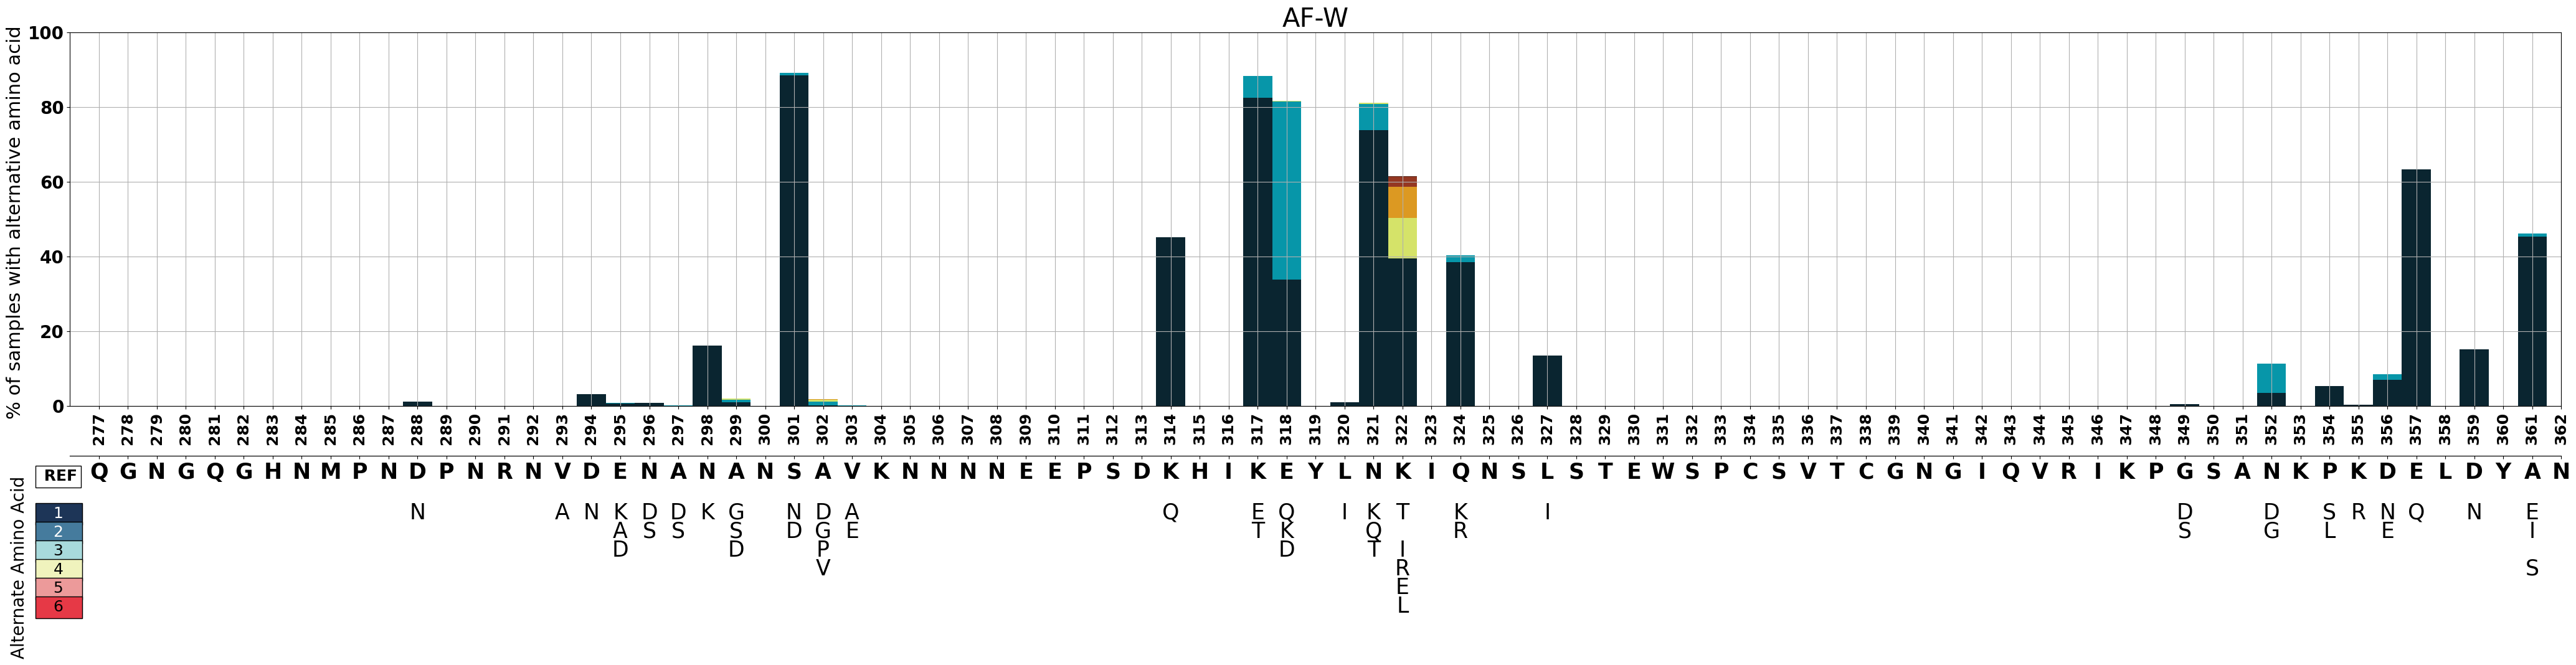

In [63]:
fig_AF_W = make_pop_plots(pop_bool, 'AF-W', 3450)

**Figure Legend: Variation in c-terminal of csp in samples from West Africa.**

#### Showing allele proportions for Pf7 by subpopulations

The final figure will display each subpopulation stacked on top of each other with a shared x-axis. We will update the make_pop_plots function to generate a subplot.

In [44]:
def make_pop_plots2(pop_bool, pop, pop_size, subplot_num):
    """
    Generate a stacked bar graph representing the percentage of samples with alternative amino acids
    for a given population.

    Parameters:
        pop_bool (pd.DataFrame): DataFrame containing boolean values for alternative amino acid presence.
        pop (str): Name of the population.
        pop_size (int): Size of the population.
        subplot_num (AxesSubplot): Subplot to use for plotting.

    Returns:
        AxesSubplot: The subplot containing the generated stacked bar graph.
    """

    # Extract relevant columns from the DataFrame
    ns_bool_T = pop_bool[[pop, 'aa_change', 'aa_position', 'OG_aa', 'mut_aa']]

    # Create a copy of the DataFrame for modification
    ns_bool_T = ns_bool_T.copy()

    # Add columns for count and count percentage
    ns_bool_T.loc[:, 'count'] = ns_bool_T[[pop]].sum(axis=1)
    ns_bool_T.loc[:, 'count_percentage'] = ns_bool_T['count'].apply(lambda x: (x / pop_size) * 100)

    # Add a ranking column and set the index
    ns_bool_T = ns_bool_T.reset_index(drop=True).sort_values(by=['aa_position', 'count_percentage'], ascending=[True, False])
    ns_bool_T.loc[:, 'alt_acid_number'] = ns_bool_T['aa_change'].map(rank_dict)
    ns_bool_T = ns_bool_T.set_index(['aa_position', 'OG_aa', 'alt_acid_number'])

    # Unstack the index by count percentage and group by amino acid position
    count_unstacked = ns_bool_T['count_percentage'].unstack().groupby(['aa_position', 'OG_aa']).first()

    # Create a new DataFrame with empty cells and merge it with the existing one
    aa_position = np.arange(277, 363)
    og_aa = list("QGNGQGHNMPNDPNRNVDENANANSAVKNNNNEEPSDKHIKEYLNKIQNSLSTEWSPCSVTCGNGIQVRIKPGSANKPKDELDYANDIEKKICKMEKCSSVFNVVNSSIGLIMVL")
    tuples = list(zip(aa_position, og_aa))

    cols = count_unstacked.columns
    index = pd.MultiIndex.from_tuples(tuples, names=['aa_position', 'OG_aa'])
    empty_df = pd.DataFrame(np.nan, index, cols)
    data_to_plot = empty_df.fillna(count_unstacked).fillna(0)

    # Turn count into an int and select rows with count > 0
    ns_bool_T['count'] = ns_bool_T['count'].apply(lambda x: int(x))
    ns_bool_T.loc[ns_bool_T['count'] > 0]

    # Unstack the index by count percentage and group by amino acid position
    mut_aa_unstacked = ns_bool_T.loc[ns_bool_T['count'] > 0]['mut_aa'].unstack().groupby(['aa_position', 'OG_aa']).first()

    # Plot the stacked bar graph on the specified subplot
    subplot_num = data_to_plot.plot(kind='bar',
                                    stacked=True,
                                    y=[1, 2, 3, 4, 5, 6],
                                    figsize=(15, 10),
                                    width=0.9,
                                    color=[colors[i] for i in column_list],
                                    linewidth=1,
                                    ax=subplot_num,
                                    sharex=True,
                                    legend=False)

    # Create a twin axis for additional annotations
    twin = subplot_num.twinx()
    twin.set_ylabel(pop, fontsize=8)
    twin.set_yticks([])
    twin.set_yticklabels([])

    # Customize y-axis and x-axis of the bar graph
    subplot_num.set_yticks([0, 20, 40, 60, 80, 100])
    subplot_num.set_yticklabels(["0", "20", "40", "60", "80", "100"], fontsize=10)
    subplot_num.set_xlim(-1, 85)
    subplot_num.set_xticks(data_to_plot.reset_index().index)
    subplot_num.set_xlabel(' ')
    subplot_num.set_xticklabels(aa_position, fontweight='bold', fontsize=10)

    return subplot_num

Now, we will invoke the function for each subpopulation, establish the x-axis, and incorporate a legend.

Text(0.09, 0.001, 'Alt. Amino Acid')

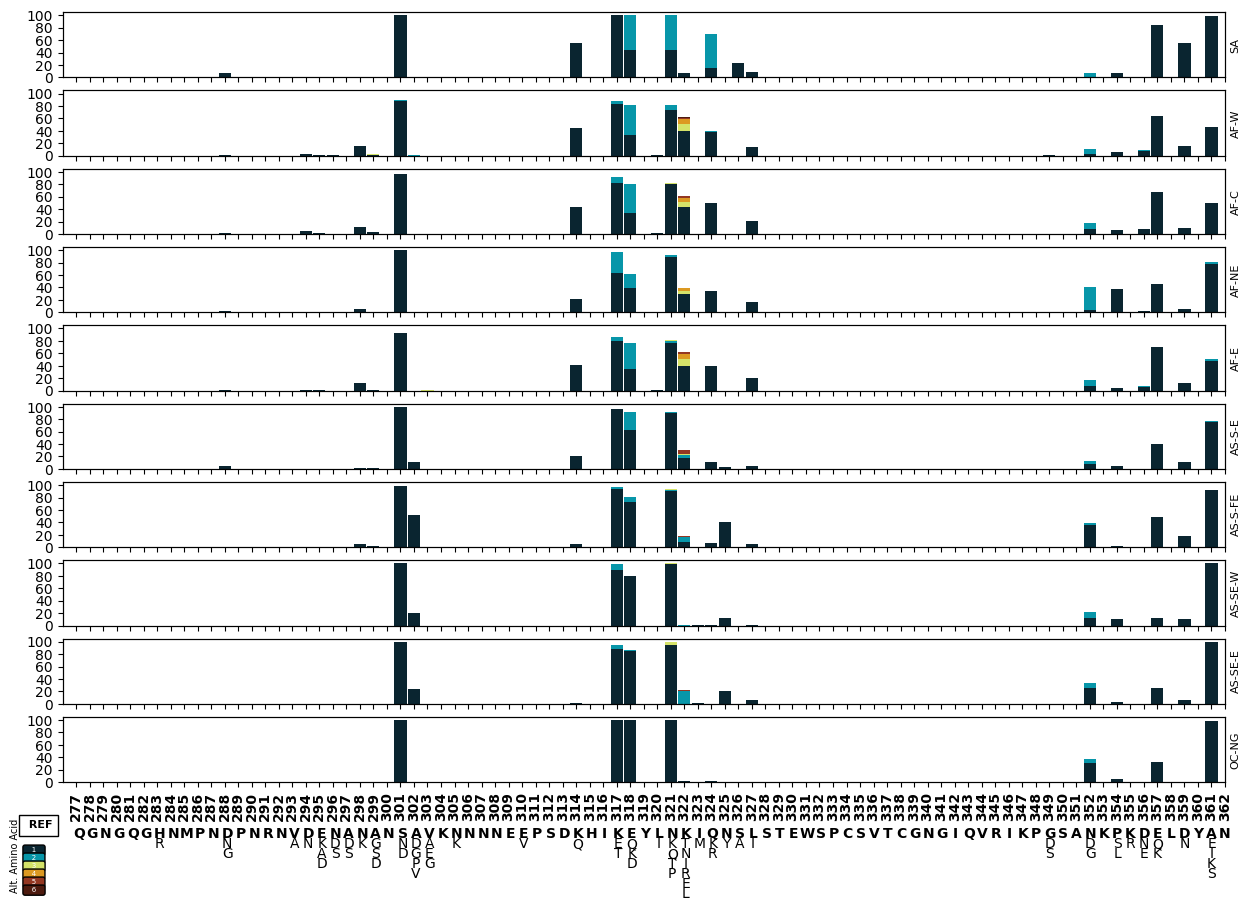

In [76]:
# Set up a 10-subplot figure with shared x and y axes
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, sharex=True, sharey=True, figsize=(50, 200))

# Plot stacked bar graphs for different populations using the make_pop_plots2 function
make_pop_plots2(pop_bool, 'SA', 152, ax1)
make_pop_plots2(pop_bool, 'AF-W', 3450, ax2)
make_pop_plots2(pop_bool, 'AF-C', 291, ax3)
make_pop_plots2(pop_bool, 'AF-NE', 83, ax4)
make_pop_plots2(pop_bool, 'AF-E', 927, ax5)
make_pop_plots2(pop_bool, 'AS-S-E', 135, ax6)
make_pop_plots2(pop_bool, 'AS-S-FE', 1066, ax7)
make_pop_plots2(pop_bool, 'AS-SE-W', 1710, ax8)
make_pop_plots2(pop_bool, 'AS-SE-E', 3166, ax9)
make_pop_plots2(pop_bool, 'OC-NG', 274, ax10)

# Create secondary axes underneath for alternative amino acid labels

# Create OG aa x-axis
ax11 = fig.add_axes((0.1, 0.07, 0.8, 0.0), frameon=False)
ax11.yaxis.set_visible(False)
ax11.set_xlim(-4, 85)
ax11.set_xticks(test.reset_index().index)
ax11.tick_params(length=0)
ax11.set_xticklabels(og_aa_plot, fontweight='bold', fontsize=10)

# Create alternative x-axes for different amino acid labels
for i, labels in enumerate([one, two, three, four, five, six]):
    ax11 = fig.add_axes((0.1, 0.07 - (i + 1) * 0.01, 0.8, 0.0), frameon=False)
    ax11.yaxis.set_visible(False)
    ax11.set_xlim(-4, 85)
    ax11.set_xticks(test.reset_index().index)
    ax11.tick_params(length=0)
    ax11.set_xticklabels(labels, fontsize=10)

# Add text boxes for alternative amino acid labeling
fig.text(0.1, 0.064, " REF", bbox=dict(facecolor='white'), fontsize=8, fontweight='bold')
for i, color in enumerate(colors.values(), start=1):
    fig.text(0.1, 0.048 - i * 0.008, f"   {i}   ", bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.3'), fontsize=5, color='white')

# Add text for the alternative amino acid axis
fig.text(0.09, 0.001, "Alt. Amino Acid", rotation=90, fontsize=7)

**Figure Legend: Variation in c-terminal of csp.** The x-axis shows amino acid positions and the y-axis the proportion of non-reference alleles in different sub-populations. Different alternative amino acids are represented by different colours as represented by the legend below the x-axis.

### Save the plot

In [46]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/figure_csp_c_terminal_barstacked.pdf', dpi=480, bbox_inches="tight") # increase the dpi for higher resolution